In [1]:
version='kings_xgboost_v5'

'''
OG xgboost + with bigger training data only seattle: THis shows the results in table 3




'''

'\nOG xgboost + with bigger training data only seattle: THis shows the results in table 3\n\n\n\n\n'

In [2]:

import collections
import copy
import csv
import math
import numbers
import random
import threading
import time
import types
import warnings
from functools import partial, update_wrapper

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, NeighborLoader, NeighborSampler
from torch_geometric.nn import SAGEConv, TransformerConv,NNConv
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
import torch_geometric
torch_geometric.__version__
torch.__version__
print(torch.version.cuda)
import sys
# sys.path
# sys.path.append('zestimate-neural-net')
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import DataFrame, SparkSession
# from pyspark.sql import functions as F
# from pyspark.sql import types as T
# from pyspark.sql.window import Window

# from aip_spark_sdk import AwsHelper
import pandas as pd
import numpy as np
import collections
import copy
import csv
import math
# import numbers
# import random
# import threading
# import time
# import types
import warnings
from functools import partial, update_wrapper

import matplotlib.pyplot as plt
# import networkx as nx
import numpy as np
import pandas as pd
# import torch.nn as nn
# import torch.nn.functional as F
# from sklearn.metrics import mean_absolute_error, median_absolute_error
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.metrics import r2_score
from sklearn.neighbors import BallTree
pd.set_option('display.max_columns', None)
print(torch.cuda.is_available())

11.6
True


In [3]:
def get_feature_dict():
    num_features = [
        "latitude",
        "longitude",
        "year_built",
        "year_reno",
        "grade",
        "fbsmt_grade",
        "condition",
        "stories",
        "beds",
        "bath_full",
        "bath_3qtr",
        "bath_half",
    ]
    num_log_features = [
        "land_val",
        "imp_val",
        "sqft_lot",
        "sqft",
        "sqft_1",
        "sqft_fbsmt",
        "garb_sqft",
        "gara_sqft",
    ]
    cat_features = [
        # "area",
        "city",
       "submarket",
        "zoning",
        # "present_use",

        # "wfnt",
        # "golf",
        # "greenbelt",
        # "noise_traffic",
        # "view_rainier",
        # "view_olympics",
        # "view_cascades",
        # "view_territorial",
        # "view_skyline",
        # "view_sound",
        # "view_lakewash",
        # "view_lakesamm",
        # "view_otherwater",
        # "view_other",
        
        # "sale_date_yyyymm",
        # "sale_decade",
        # "sale_year",
        # "sale_week",
    ]
    ord_features = [
        # "stories",
        # "beds",
        # "bath_full",
        # "bath_3qtr",
        # "bath_half",
    ]
    time_features = ["sale_date",]

    feature_dict = {
        "nums": num_features,
        "num_logs": num_log_features,
        "cats": cat_features,
        "ords": ord_features,
        "time": time_features,
    }

    return feature_dict


feature_dict = get_feature_dict()

id_cols = ["sale_id", "pinx", "submarket"]
response_col = "sale_price"
feature_cols = set(
    feature_dict["nums"] +
    feature_dict["num_logs"] +
    feature_dict["cats"] +
    feature_dict["ords"] +
    feature_dict["time"]
)

In [4]:
df=pd.read_csv('kingcountysales.csv')
df["sale_date"]=pd.to_datetime(df["sale_date"])
max_train_date = "2021-01-01"
min_train_date = "2016-01-01"
sample_beg_date= "2015-01-01"
df_1= df[df["sale_date"] >= min_train_date].copy()

In [5]:
class ResponseTransformer:
    """Response transformer."""
    def __init__(self):
        self.median = None

    def fit(self, y):
        y_trans = np.log1p(y)
        self.median = np.median(y_trans)
        return self

    def transform(self, y):
        y = np.log1p(y) - self.median
        return y

    def fit_transform(self, y):
        return self.fit(y).transform(y)

    def inverse_transform(self, y):
        y = np.expm1(y + self.median)
        return y

In [6]:
def prepare_missing(df):
    df = (
        df
        .assign(imp_val=lambda x: x['imp_val'].replace(0, np.nan))
        .assign(land_val=lambda x: x['land_val'].replace(0, np.nan))
        .assign(sqft=lambda x: x['sqft'].replace(0, np.nan))
        .assign(beds=lambda x: x['beds'].replace(54, np.nan))
    )
    return df
def clean_sqft(df):
    sqft_1 = df.query('sqft < sqft_1')['sqft_1']
    sqft_fbsmt = df.query('sqft < sqft_1')['sqft_fbsmt']
    df.loc[df['sqft'] < df['sqft_1'], 'sqft'] = sqft_1 + sqft_fbsmt
    return df

def clean_year_built(df):
    df['build_type'] = 'Standard'
    df.loc[(df['year_built'] - 1) == pd.to_datetime(df['sale_date']).dt.year, 'build_type'] = 'New Construction'
    df.loc[(df['year_built'] - 1) > pd.to_datetime(df['sale_date']).dt.year, 'build_type'] = 'Lot Sale'
    return df

def prepare_outliers(df):
    df = (
        df
        .pipe(clean_sqft)
        .pipe(clean_year_built)
    )
    return df

def preprocessor(df_1, feature_c):
    df_out=df_1.copy()
    # feature_cols=feature_c.copy()
    
    '''
    categorical features: replace each category with its price statistics from prior years  
    '''
    df_sample=  df[(df["sale_date"] < min_train_date) & (df["sale_date"] >= sample_beg_date)].copy()
    trans_1=ResponseTransformer()
    df_sample[response_col]=trans_1.fit_transform(df_sample[response_col].values)
    # df_sample[response_col]= np.log1p(df_sample[response_col].values) - df_sample[response_col].median()
    for cat_col in feature_dict['cats']:
        cat_stats= df_sample[[cat_col,response_col]].groupby(cat_col).describe().add_prefix(f'{cat_col}_')[f'{cat_col}_sale_price'].reset_index()
        df_out=df_out.merge(cat_stats, how='left', on=cat_col)
        print(cat_col)
        print(df_out.shape)
        print(df_out['sale_date'].isna().sum())
        df_out.drop(columns=cat_col, inplace=True)
        feature_cols.update(list(cat_stats.columns))
        feature_cols.remove(cat_col)
        
    '''
    temporal adjusting 
    '''
    print(df_out['sale_date'].isna().sum())
    date_time = df_out['sale_date']

    timestamp_s = date_time.dt.week
    # df_1['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    # df_1['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df_out['year_sin'] = np.sin(timestamp_s * (2 * np.pi / 52))
    df_out['year_cos'] = np.cos(timestamp_s * (2 * np.pi / 52))
    # df_out.drop(columns='sale_date', inplace=True)
    df_out['trans_year']=date_time.dt.year
    feature_cols.update(['trans_year','year_sin','year_cos'])
    feature_cols.remove('sale_date')
    
    '''
    taking log
    '''
    
    df_out[feature_dict['num_logs']]=np.log1p(df_out[feature_dict['num_logs']])
    '''
    filling missing values
    '''
    
    df_out.fillna(df_out.median(), inplace=True)
    # print(df_out.isna().sum())
    # df_out.dropna(inplace=True)
    return df_out, feature_cols
        

In [7]:
df_1.shape

(161512, 47)

In [8]:
feature_cols = set(
    feature_dict["nums"] +
    feature_dict["num_logs"] +
    feature_dict["cats"] +
    feature_dict["ords"] +
    feature_dict["time"]
)
old_feat_col=feature_cols.copy()
df_1=prepare_missing(df_1)
df_1=prepare_outliers(df_1)
df_out,feature_cols_2=preprocessor(df_1, feature_cols)
df_out["sale_year"] = df_out["sale_date"].dt.year
df_out["sale_month"] = df_out["sale_date"].dt.month
df_out["sale_week"] = df_out["sale_date"].dt.isocalendar().week
df_out["sale_day"] = df_out["sale_date"].dt.day

city
(161512, 56)
0
submarket
(161512, 63)
0
zoning
(161512, 70)
0
0


/tmp/ipykernel_410/1722977719.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  timestamp_s = date_time.dt.week
/tmp/ipykernel_410/1722977719.py:76: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_out.fillna(df_out.median(), inplace=True)
/tmp/ipykernel_410/1722977719.py:76: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_out.fillna(df_out.median(), inplace=True)


In [9]:
df_train = df_out[(df_out["sale_date"] < max_train_date) & (df_out["sale_date"] >= min_train_date)].copy()
df_train = df_train.reset_index(drop=True)
df_test = df_out[df_out["sale_date"] >= max_train_date].copy()
df_test = df_test.reset_index(drop=True)



response_transformer = ResponseTransformer()




X_train=df_train[feature_cols].copy()
y_train=response_transformer.fit_transform(df_train[response_col])

X_test=df_test[feature_cols].copy()
y_test=df_test[response_col].copy()



from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train[list(X_train.columns)]=scaler.fit_transform(X_train)
X_test[list(X_test.columns)]=scaler.transform(X_test)

/tmp/ipykernel_410/2730997172.py:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train=df_train[feature_cols].copy()
/tmp/ipykernel_410/2730997172.py:16: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test=df_test[feature_cols].copy()


In [10]:
X_train['city_max']

0         0.856149
1         0.856149
2         0.856149
3         0.063111
4        -0.377112
            ...   
130512   -0.948167
130513    0.739372
130514    0.856149
130515    0.856149
130516    0.856149
Name: city_max, Length: 130517, dtype: float64

In [11]:
def mean_percentage_error(true, pred, epsilon=1e-6):
    """Mean Percentage Error (MPE)."""
    pe = (pred - true) / (true + epsilon)
    return np.mean(pe)


def median_absolute_percentage_error(true, pred, epsilon=1e-6):
    """Median Absolute Percentage Error (MdAPE)."""
    ape = np.abs(pred - true) / (true + epsilon)
    return np.median(ape)


def median_percentage_error(true, pred, epsilon=1e-6):
    """Median Percentage Error (MdPE)."""
    pe = (pred - true) / (true + epsilon)
    return np.median(pe)


def frac_within_ci(true, pred_low, pred_high):
    """Fraction within Confidence Interval."""
    wci = (true >= pred_low) & (true <= pred_high)
    return np.mean(wci)


def mean_ci_width(true, pred_low, pred_high, epsilon=1e-6):
    """Mean Confidence Interval Width."""
    ciw = (pred_high - pred_low) / (true + epsilon)
    return np.mean(ciw)


def median_ci_width(true, pred_low, pred_high, epsilon=1e-6):
    """Median Confidence Interval Width."""
    ciw = (pred_high - pred_low) / (true + epsilon)
    return np.median(ciw)


def evaluate_preds(y_test, y_pred, y_pred_low=None, y_pred_high=None):
    output = {}
    output["Count"] = len(y_test)
    output["R2"] = r2_score(y_test, y_pred)
    output["MAE"] = mean_absolute_error(y_test, y_pred)
    output["MdAE"] = median_absolute_error(y_test, y_pred)
    output["MPE"] = mean_percentage_error(y_test, y_pred)
    output["MdPE"] = median_percentage_error(y_test, y_pred)
    output["MAPE"] = mean_absolute_percentage_error(y_test, y_pred)
    output["MdAPE"] = median_absolute_percentage_error(y_test, y_pred)
    if y_pred_low is not None and y_pred_high is not None:
        output["Pct. Within CI"] = frac_within_ci(y_test, y_pred_low, y_pred_high)
        output["Mean CI Width"] = mean_ci_width(y_test, y_pred_low, y_pred_high)
        output["Med. CI Width"] = median_ci_width(y_test, y_pred_low, y_pred_high)
    return output

In [12]:
'''
mostly referencing Reid's public notebook on kaggle for typical preprocessing steps 
https://www.kaggle.com/code/reidjohnson/house-price-eda-and-modeling-with-python

'''

"\nmostly referencing Reid's public notebook on kaggle for typical preprocessing steps \nhttps://www.kaggle.com/code/reidjohnson/house-price-eda-and-modeling-with-python\n\n"

In [13]:
'''
testing a lasso regression on this first 
'''

from sklearn import linear_model
from sklearn.pipeline import Pipeline


param_grid={'lasso_alpha': [0.1,0.3,0.7]}

lasso=linear_model.Lasso(alpha=0.1 )

lasso.fit(X_train.values,y_train.values)


y_pred_lasso=lasso.predict(X_test.values)
y_pred_lasso= response_transformer.inverse_transform(y_pred_lasso)
evaluate_preds(y_test.values, y_pred_lasso)


{'Count': 30995,
 'R2': 0.17504533509167952,
 'MAE': 361386.6391555889,
 'MdAE': 181976.47986439988,
 'MPE': -0.2176346550389505,
 'MdPE': -0.22381032957133953,
 'MAPE': 0.26537470166652255,
 'MdAPE': 0.23421713356449164}

In [14]:
X_train['land_val']

0        -1.001175
1        -2.531141
2        -2.216219
3        -0.545919
4        -1.907637
            ...   
130512    2.680359
130513    0.436039
130514    0.436039
130515    0.450687
130516   -0.536338
Name: land_val, Length: 130517, dtype: float64

In [15]:
lasso.predict(X_test.values)

array([ 0.19544409, -0.46195809, -0.31632016, ..., -0.08725179,
        1.07282905,  0.40921047])

In [16]:
X_train.columns

Index(['submarket_50%', 'bath_full', 'trans_year', 'submarket_min',
       'city_count', 'submarket_25%', 'city_50%', 'year_reno', 'city_min',
       'zoning_mean', 'city_25%', 'sqft_lot', 'zoning_count', 'city_max',
       'sqft_fbsmt', 'beds', 'grade', 'bath_3qtr', 'imp_val', 'submarket_75%',
       'zoning_std', 'city_75%', 'city_mean', 'land_val', 'year_cos',
       'submarket_count', 'zoning_50%', 'condition', 'garb_sqft', 'zoning_25%',
       'year_sin', 'submarket_max', 'latitude', 'year_built', 'bath_half',
       'zoning_min', 'longitude', 'submarket_mean', 'sqft', 'submarket_std',
       'zoning_max', 'gara_sqft', 'zoning_75%', 'fbsmt_grade', 'sqft_1',
       'stories', 'city_std'],
      dtype='object')

In [17]:
X_train

,submarket_50%,bath_full,trans_year,submarket_min,city_count,submarket_25%,city_50%,year_reno,city_min,zoning_mean,city_25%,sqft_lot,zoning_count,city_max,sqft_fbsmt,beds,grade,bath_3qtr,imp_val,submarket_75%,zoning_std,city_75%,city_mean,land_val,year_cos,submarket_count,zoning_50%,condition,garb_sqft,zoning_25%,year_sin,submarket_max,latitude,year_built,bath_half,zoning_min,longitude,submarket_mean,sqft,submarket_std,zoning_max,gara_sqft,zoning_75%,fbsmt_grade,sqft_1,stories,city_std
0,1.154536,-0.841701,-1.376047,-1.197239,1.459587,1.209738,0.471282,-0.195941,-0.925064,-0.018141,0.382524,-0.961205,-0.929073,0.856149,-0.814674,-1.562769,-2.316161,-0.810841,-1.669431,1.330566,0.406714,0.451003,0.452151,-1.001175,1.600180,0.065233,-0.060246,0.607246,-0.51112,0.136693,0.244658,1.381860,-3.073146,-2.375813,-0.914161,0.670759,-3.970968,1.286467,-1.592863,1.664532,-0.798090,-1.077061,-0.026732,-0.804323,-0.435703,-0.993634,0.681488
1,-0.128158,0.604881,-1.376047,0.030640,1.459587,-0.166455,0.471282,-0.195941,-0.925064,0.673413,0.382524,-0.403283,2.017033,0.856149,-0.814674,-0.472358,-1.452607,-0.810841,-1.216774,-0.061033,0.654463,0.451003,0.452151,-2.531141,1.600180,0.037614,0.640066,0.607246,-0.51112,0.575943,0.244658,-0.330177,-3.073147,-1.550394,-0.914161,-1.327248,-3.970968,-0.115717,-0.624242,0.438207,1.084385,-1.077061,0.724711,-0.804323,0.019002,-0.063291,0.681488
2,-0.258708,-0.841701,-1.376047,-1.443954,1.459587,-0.390569,0.471282,-0.195941,-0.925064,0.673413,0.382524,-0.376396,2.017033,0.856149,-0.814674,-1.562769,-0.589053,-0.810841,-1.932028,-0.197372,0.654463,0.451003,0.452151,-2.216219,1.568843,-1.359128,0.640066,-0.742319,-0.51112,0.575943,0.412526,0.392359,-3.073147,-1.105937,-0.914161,-1.327248,-3.970968,-0.293233,-2.090963,0.396997,1.084385,-1.077061,0.724711,-0.804323,-0.988606,-0.993634,0.681488
3,0.398463,0.604881,-1.376047,0.362823,-0.685973,0.454513,0.598153,-0.195941,0.476657,-1.585319,0.577832,-0.444426,-0.510705,0.063111,1.406602,-0.472358,-0.589053,-0.810841,-1.084430,0.524578,0.337136,0.900075,0.761584,-0.545919,1.600180,0.710338,-1.679843,-0.742319,-0.51112,-1.570644,0.244658,0.280948,-3.073145,-0.661481,-0.914161,-0.749279,-3.970968,0.501995,0.439264,0.374804,0.351481,0.825369,-1.795061,0.304846,0.040842,-0.993634,0.657841
4,1.095379,-0.841701,-1.376047,1.602576,-0.661320,1.104556,-0.792589,-0.195941,0.056407,0.682998,-0.791136,1.021594,-0.957761,-0.377112,-0.814674,-0.472358,-2.316161,-0.810841,-2.281091,1.003057,4.632662,-0.727348,-0.789338,-1.907637,1.517121,0.623535,0.637120,0.607246,-0.51112,-0.231405,0.575461,1.219748,-3.073147,-1.042443,-0.914161,1.056569,-3.970967,1.089809,-1.223087,0.264125,-0.300643,-1.077061,1.367680,-0.804323,-0.025243,-0.993634,-0.424105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130512,2.984032,2.051463,1.414804,1.471233,-1.063417,2.710581,3.290538,5.122897,3.862340,2.935283,3.970381,0.401076,-0.958558,-0.948167,1.517452,0.618053,1.138056,-0.810841,1.039677,3.032193,-2.670337,2.329244,2.933695,2.680359,1.600180,-1.678721,3.173845,-0.742319,-0.51112,3.964096,0.244658,2.569939,0.404468,-1.963103,0.988221,3.674740,0.255357,2.909671,1.728068,3.461845,-0.636837,0.909259,2.141852,1.414014,1.022823,1.797395,-3.257535
130513,-1.368311,0.604881,1.414804,-0.730929,0.188015,-1.457073,-0.360509,5.130852,-0.716128,-0.338054,-0.528058,0.070056,0.993825,0.739372,1.321629,1.708464,0.274502,2.254919,0.882768,-1.329721,0.065684,0.024395,-0.261775,0.436039,1.600180,-1.741850,-0.378814,-0.742319,-0.51112,-0.466610,0.244658,-2.132841,0.058652,-0.756721,-0.914161,-0.456304,0.219978,-1.415599,1.337556,-0.349595,0.605745,1.055759,-0.166248,1.414014,0.147340,0.867052,1.180401
130514,-0.128158,0.604881,1.414804,0.030640,1.459587,-0.166455,0.471282,5.138806,-0.925064,0.673413,0.382524,-0.210339,2.017033,0.856149,1.460241,0.618053,0.274502,0.722039,1.

In [18]:
def median_absolute_percentage_error_2(true, pred, epsilon=1e-6):
    """Median Absolute Percentage Error (MdAPE)."""
    ape = np.abs(response_transformer.inverse_transform(pred )- true) / (true + epsilon)
    return np.median(ape)


In [19]:
import xgboost as xgb
from xgboost import XGBRegressor
y_test_log=response_transformer.transform(y_test.values)
eval_set = [(X_test.values, y_test_log)]
xgb_model=XGBRegressor(objective='reg:squarederror', gpu_id=0, eta=0.1,
                      gamma=0.01,reg_lambda=0.5,max_depth=10, reg_alpha=0.5, sampling_method='uniform',
                      subsample=0.9, colsample_bytree=0.9, eval_metric= 'rmse', early_stopping_rounds=10)

xgb_model.fit(X_train.values,y_train.values,eval_set=eval_set)

[0]	validation_0-rmse:0.50499
[1]	validation_0-rmse:0.46085
[2]	validation_0-rmse:0.42234
[3]	validation_0-rmse:0.39250
[4]	validation_0-rmse:0.36541
[5]	validation_0-rmse:0.34319
[6]	validation_0-rmse:0.32447
[7]	validation_0-rmse:0.30950
[8]	validation_0-rmse:0.29817
[9]	validation_0-rmse:0.28892
[10]	validation_0-rmse:0.28171
[11]	validation_0-rmse:0.27694
[12]	validation_0-rmse:0.27346
[13]	validation_0-rmse:0.27040
[14]	validation_0-rmse:0.26893
[15]	validation_0-rmse:0.26729
[16]	validation_0-rmse:0.26627
[17]	validation_0-rmse:0.26570
[18]	validation_0-rmse:0.26556
[19]	validation_0-rmse:0.26571
[20]	validation_0-rmse:0.26732
[21]	validation_0-rmse:0.26755
[22]	validation_0-rmse:0.26780
[23]	validation_0-rmse:0.26822
[24]	validation_0-rmse:0.26866
[25]	validation_0-rmse:0.26929
[26]	validation_0-rmse:0.26963
[27]	validation_0-rmse:0.27024


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=10,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, gamma=0.01, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [20]:
y_pred_xgb=xgb_model.predict(X_test.values)
y_pred_xgb= response_transformer.inverse_transform(y_pred_xgb)
evaluate_preds(y_test.values, y_pred_xgb)
pd.DataFrame([evaluate_preds(y_test, y_pred_xgb)], index=[f"{version}"])

,Count,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
kings_xgboost_v5,30995,0.602607,237144.139867,117719.6875,-0.115315,-0.133258,0.183872,0.153516


In [21]:
df_new=df_test.copy()
# df_new['recordingdate']=pd.to_datetime(df_new['recordingdate'])
# df_new['week_period']=df_new['recordingdate'].dt.to_period('w')
df_new['y_pred']=y_pred_xgb.flatten()
df_new['indive_mape']=np.abs(df_new['y_pred'].values-df_new[response_col].values)/df_new[response_col].values
print('30%', len(df_new.loc[df_new['indive_mape']<=0.3])/len(df_new))
print('10%', len(df_new.loc[df_new['indive_mape']<=0.1])/len(df_new))

30% 0.8412647201161477
10% 0.32740764639457975


In [22]:
city_dict=dict(zip(df_1['sale_id'].values, df_1['city'].values))
df_sample=df_test[['sale_id','sale_date','sale_price']]
df_sample['city']=df_sample['sale_id'].map(city_dict)
df_sample['xgb_pred']=y_pred_xgb

/tmp/ipykernel_410/1155391526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['city']=df_sample['sale_id'].map(city_dict)
/tmp/ipykernel_410/1155391526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['xgb_pred']=y_pred_xgb


In [23]:
pd.DataFrame([evaluate_preds(df_sample['sale_price'].values, df_sample['xgb_pred'].values)], index=[f"GNN_v{version}"])

,Count,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE
GNN_vkings_xgboost_v5,30995,0.602607,237144.139867,117719.6875,-0.115315,-0.133258,0.183872,0.153516


In [24]:
df_gnn=pd.read_csv('tgnn_kc_preds.csv')

In [25]:
df_sample['tgnn_pred']=df_gnn['tgnn_pred'].values

/tmp/ipykernel_410/2541207210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['tgnn_pred']=df_gnn['tgnn_pred'].values


In [26]:
df_sample

,sale_id,sale_date,sale_price,city,xgb_pred,tgnn_pred
0,2021..13,2021-01-05,825000,BELLEVUE,1.512964e+06,1459137.10
1,2021..771,2021-01-13,300000,SEATTLE,6.122156e+05,375879.50
2,2021..864,2021-01-04,400000,KING COUNTY,4.787576e+05,640730.10
3,2021..1400,2021-01-13,523000,KING COUNTY,5.244018e+05,605271.25
4,2021..1642,2021-01-06,560000,SEATTLE,6.972447e+05,561521.50
...,...,...,...,...,...,...
30990,2021..48056,2021-12-23,995950,SEATTLE,7.059105e+05,1096662.10
30991,2021..48108,2021-12-13,950000,SEATTLE,9.184694e+05,1063680.90
30992,2021..48212,2021-12-22,857000,SHORELINE,6.500392e+05,839805.10
30993,2021..48260,2021-12-20,5250000,BELLEVUE,2.894095e+06,5247081.00


In [27]:
df_sample['tgnn_mape']=np.abs(df_sample['tgnn_pred'].values-df_sample['sale_price'].values)/df_sample['sale_price'].values
df_sample['xgb_mape']=np.abs(df_sample['xgb_pred'].values-df_sample['sale_price'].values)/df_sample['sale_price'].values

/tmp/ipykernel_410/2572649812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['tgnn_mape']=np.abs(df_sample['tgnn_pred'].values-df_sample['sale_price'].values)/df_sample['sale_price'].values
/tmp/ipykernel_410/2572649812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['xgb_mape']=np.abs(df_sample['xgb_pred'].values-df_sample['sale_price'].values)/df_sample['sale_price'].values


In [28]:
df_sample['xgb_mape'].describe()

count    30995.000000
mean         0.183872
std          0.223230
min          0.000005
25%          0.077511
50%          0.153516
75%          0.247495
max         12.770095
Name: xgb_mape, dtype: float64

In [30]:
by_city=df_sample.groupby('city').mean()

/tmp/ipykernel_410/1892331013.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_city=df_sample.groupby('city').mean()


In [31]:
import seaborn as sns

In [36]:
by_city.reset_index(inplace=True)

In [ ]:
melted

In [37]:
melted=pd.melt(by_city, id_vars=['city'], value_vars=['tgnn_mape','xgb_mape'])

In [43]:
melted=melted.rename(columns={'variable':'Model'})

<Axes: xlabel='city', ylabel='value'>

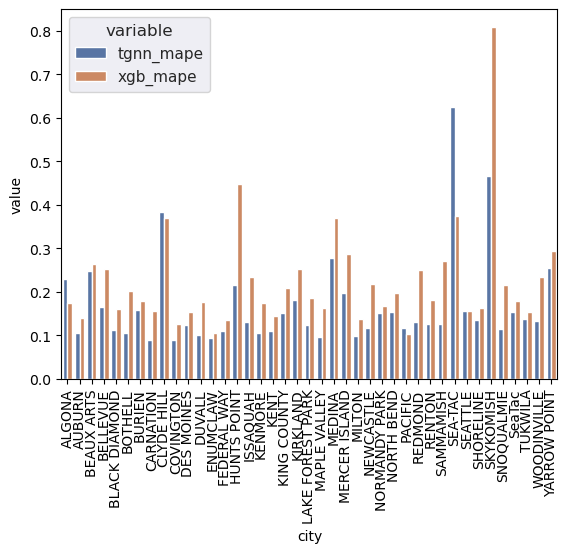

In [38]:
plt.xticks(rotation=90)
sns.set(rc={'figure.figsize':(30,30)})
sns.barplot(data=melted, x="city", y="value", hue="variable")

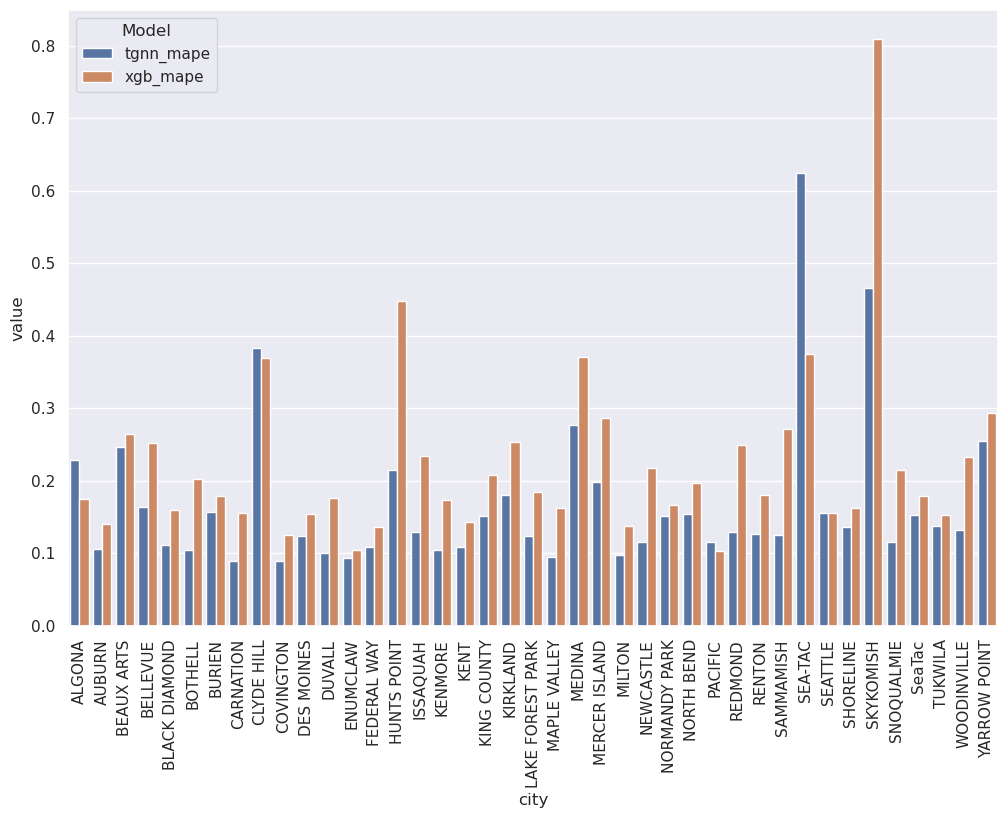

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,8)})  # Set the figure size
barplot = sns.barplot(data=melted, x="city", y="value", hue="Model")
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

In [45]:
df_sample['sale_month']=df_sample['sale_date'].dt.to_period('m')

/tmp/ipykernel_410/591820838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['sale_month']=df_sample['sale_date'].dt.to_period('m')


/tmp/ipykernel_410/3438952544.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sample.groupby('sale_month').mean()[['tgnn_mape','xgb_mape']].reset_index().plot()


<Axes: >

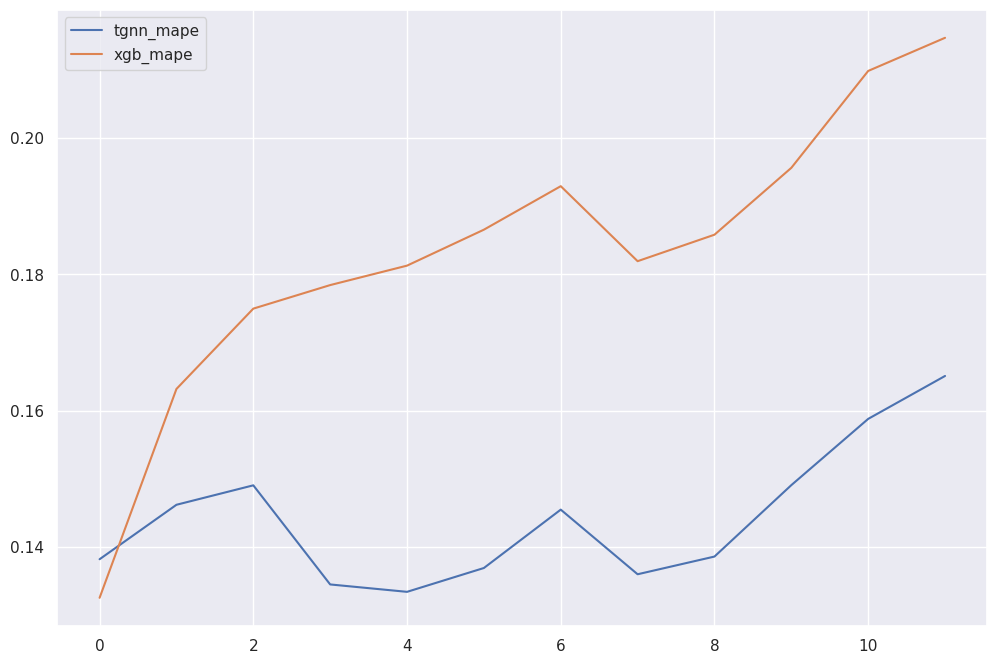

In [46]:
# plt.title('model performance over months') 
sns.set(rc={'figure.figsize':(12,8)})
df_sample.groupby('sale_month').mean()[['tgnn_mape','xgb_mape']].reset_index().plot()

/tmp/ipykernel_410/641494142.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_data = df_sample.groupby('sale_month').mean()[['tgnn_mape','xgb_mape']].reset_index()


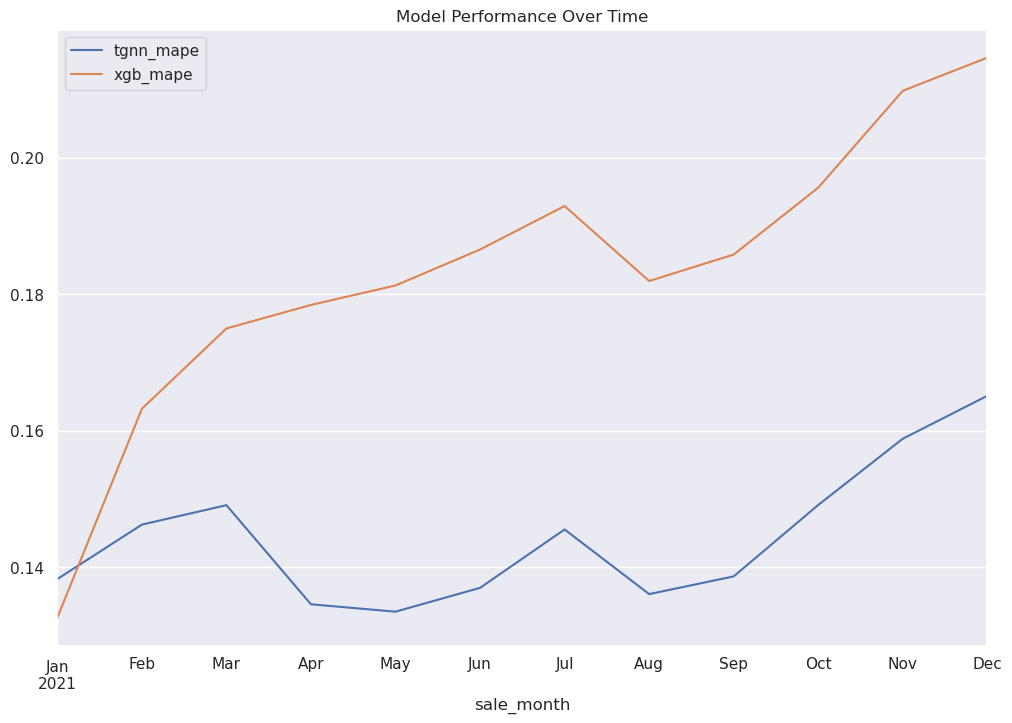

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,8)})  # Set the figure size
plot_data = df_sample.groupby('sale_month').mean()[['tgnn_mape','xgb_mape']].reset_index()
plot = plot_data.plot(x='sale_month', y=['tgnn_mape', 'xgb_mape'])

plt.title('Model Performance Over Time')  # Add a title to the plot
plt.show()